<a href="https://colab.research.google.com/github/AbhigyanSingh97/Auto-Image-Caption-Generator/blob/master/imagecaptioning_with_resNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from os import listdir
import pickle
from keras.applications.resnet import ResNet50,preprocess_input
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model

Using TensorFlow backend.


In [ ]:
def extract_features(dir):#Load ResNet50 and read every images from the dir and predict it's feature in 1-D
  model = ResNet50()
  model.layers.pop() #removed the last layer of the model
  model = Model(inputs = model.inputs,outputs = model.layers[-1].output)
  print(model.summary())
  features = dict()
  for name in listdir(dir):
    filename = dir + '/' + name
    img = load_img(filename,target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img,verbose=0)
    id = name.split('.')[0]
    features[id] = feature
    print('>%s' % name)
  return features

In [ ]:
dir = '/content/drive/My Drive/data/flickr-8/flickr-8/Images'
features = extract_features(dir)

In [ ]:
len(features)

8091

In [ ]:
pickle.dump(features,open('ResNet_50features.pkl','wb'))

# Loading the captions to each images

In [ ]:
def load_doc(filename):
  file = open(filename,'r') #Loading the text as read only
  text = file.read()
  file.close()
  return text

In [ ]:
def load_descriptions(doc):
  mapping = dict()
  for line in doc.split('\n'):#splitting by white space
    tokens = line.split()
    if len(line)<2:
      continue
    image_id,image_desc = tokens[0],tokens[1:]
    image_id = image_id.split('.')[0]
    image_desc = ' '.join(image_desc)
    if image_id not in mapping:
      mapping[image_id] = image_desc
  return mapping

In [ ]:
filename = "/content/drive/My Drive/data/flickr-8/flickr-8/captions.txt"
doc = load_doc(filename)
descriptions = load_descriptions(doc)

In [ ]:
len(descriptions)

8092

## Cleaning the captions

In [ ]:
import string
import re 
import nltk

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc in descriptions.items():
		desc = desc.split()
		desc = [word.lower() for word in desc]
		desc = [w.translate(table) for w in desc]
		desc = [word for word in desc if len(word)>1]
		descriptions[key] =  ' '.join(desc)

In [ ]:
def save_doc(descriptions,filename):
  lines = list()
  for key, desc in descriptions.items():
    lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename,'w')
  file.write(data)
  file.close()

In [ ]:
clean_descriptions(descriptions)

In [ ]:
descriptions

{'image,caption': '',
 '1000268201_693b08cb0e': 'child in pink dress is climbing up set of stairs in an entry way',
 '1001773457_577c3a7d70': 'black dog and spotted dog are fighting',
 '1002674143_1b742ab4b8': 'little girl covered in paint sits in front of painted rainbow with her hands in bowl',
 '1003163366_44323f5815': 'man lays on bench while his dog sits by him',
 '1007129816_e794419615': 'man in an orange hat starring at something',
 '1007320043_627395c3d8': 'child playing on rope net',
 '1009434119_febe49276a': 'black and white dog is running in grassy garden surrounded by white fence',
 '1012212859_01547e3f17': 'dog shakes its head near the shore red ball next to it',
 '1015118661_980735411b': 'boy smiles in front of stony wall in city',
 '1015584366_dfcec3c85a': 'black dog leaps over log',
 '101654506_8eb26cfb60': 'brown and white dog is running through the snow',
 '101669240_b2d3e7f17b': 'man in hat is displaying pictures next to skier in blue hat',
 '1016887272_03199f49c4': 

In [ ]:
vocabulary = set(' '.join(descriptions.values()).split())
len(vocabulary)

4465

In [ ]:
save_doc(descriptions,'descriptions.txt')

# taking out the train data

In [ ]:
def load_set(filename):#load the train label of pic
  doc = load_doc(filename)
  dataset = list()
  for line in doc.split('\n'):
    if len(line) < 1:#skip empty line
      continue
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)

In [ ]:
def load_clean_descriptions(filename,dataset):#Loading the cleaned description and seperating image id and image description
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0],tokens[1:]
    if image_id in dataset:
      if image_id not in descriptions:
        descriptions[image_id] = list()
      desc = 'startseq '+' '.join(image_desc)+' endseq'
      descriptions[image_id].append(desc)
  return descriptions

In [ ]:
def load_photo_features(filename,dataset):#Loading features for every images from the extract feature function
  all_features = pickle.load(open(filename,'rb'))
  features = {k:all_features[k] for k in dataset}
  return features

In [ ]:
filename = '/content/drive/My Drive/data/flickr-8/flickr-8/Flickr_8k.trainImages.txt'
train = load_set(filename)
len(train)

6000

In [ ]:
train_descriptions = load_clean_descriptions('descriptions.txt',train)
len(train_descriptions)

6000

In [ ]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq'],
 '1003163366_44323f5815': ['startseq man lays on bench while his dog sits by him endseq'],
 '1007129816_e794419615': ['startseq man in an orange hat starring at something endseq'],
 '1007320043_627395c3d8': ['startseq child playing on rope net endseq'],
 '1009434119_febe49276a': ['startseq black and white dog is running in grassy garden surrounded by white fence endseq'],
 '1012212859_01547e3f17': ['startseq dog shakes its head near the shore red ball next to it endseq'],
 '1015118661_980735411b': ['startseq boy smiles in front of stony wall in city endseq'],
 '1015584366_dfcec3c85a': ['startseq black dog leaps over log endseq'],
 '101654506_8eb26cfb60': ['start

In [ ]:
train_features = load_photo_features('/content/ResNet_50features.pkl',train)
len(train_features)

6000

# Creating Model with LSTM

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model,load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint,EarlyStopping
from nltk.translate.bleu_score import corpus_bleu
import numpy as np

In [ ]:
#converting dictionary to list
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

In [ ]:
def create_tokenizer(descriptions):
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

3840

In [ ]:
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	for desc in desc_list:
		seq = tokenizer.texts_to_sequences([desc])[0]# encode the sequence
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def create_model(vocab_size,max_length):
  #feature extractor models
  inputs = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs)
  fe2 = Dense(256,activation='relu')(fe1)
  #sequence models
  inputs1 = Input(shape = (max_length,))
  se1 = Embedding(vocab_size,256,mask_zero = True)(inputs1)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  #decoder model
  decoder = add([fe2,se3])
  decoder1 = Dense(256,activation = 'relu')(decoder)
  outputs = Dense(vocab_size,activation='softmax')(decoder1)

  model = Model(inputs = [inputs,inputs1],outputs = outputs)
  model.compile(loss='categorical_crossentropy',optimizer='adam')
  print(model.summary)
  return model

In [ ]:
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

In [ ]:
max_length = max_length(train_descriptions)
max_length

30

In [ ]:
model = create_model(vocab_size,max_length)
epochs = 55
steps = len(train_descriptions)
generator = data_generator(train_descriptions,train_features,tokenizer,max_length)
eraly_stop = EarlyStopping(monitor='loss',patience = 10)
model_check = ModelCheckpoint('Best_model',monitor = 'loss',save_best_only=True)
model.fit_generator(generator,epochs = epochs,steps_per_epoch=steps,verbose = 1,callbacks=[eraly_stop,model_check])

<bound method Network.summary of <keras.engine.training.Model object at 0x7f6fae141b00>>


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/55
6000/6000 [==============================] - 426s 71ms/step - loss: 5.0442
Epoch 2/55
6000/6000 [==============================] - 427s 71ms/step - loss: 4.2155
Epoch 3/55
6000/6000 [==============================] - 431s 72ms/step - loss: 3.9197
Epoch 4/55
6000/6000 [==============================] - 432s 72ms/step - loss: 3.7285
Epoch 5/55
6000/6000 [==============================] - 434s 72ms/step - loss: 3.5903
Epoch 6/55
6000/6000 [==============================] - 435s 73ms/step - loss: 3.4835
Epoch 7/55
6000/6000 [==============================] - 437s 73ms/step - loss: 3.3905
Epoch 8/55
6000/6000 [==============================] - 439s 73ms/step - loss: 3.3332
Epoch 9/55
6000/6000 [==============================] - 445s 74ms/step - loss: 3.2612
Epoch 10/55
6000/6000 [==============================] - 440s 73ms/step - loss: 3.1989
Epoch 11/55
6000/6000 [==============================] - 442s 74ms/step - loss: 3.1496
Epoch 12/55
6000/6000 [=============================

# Creating Test Data

In [ ]:
def word_for_id(integer, tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'
	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)# pad input
		yhat = model.predict([photo,sequence], verbose=0)# predict next word
		yhat = np.argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

In [ ]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	for key, desc_list in descriptions.items():
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
filename = '/content/drive/My Drive/data/flickr-8/flickr-8/Flickr_8k.testImages.txt'
test = load_set(filename)
len(test)

1000

In [ ]:
test_descriptions = load_clean_descriptions('descriptions.txt',test)
len(test_descriptions)

1000

In [ ]:
test_features = load_photo_features('/content/ResNet_50features.pkl',test)
len(test_descriptions)

1000

In [ ]:
model = load_model('/content/Best_model')
evaluate_model(model,test_descriptions,test_features,tokenizer,max_length)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


BLEU-1: 0.309644
BLEU-2: 0.111984
BLEU-3: 0.072317
BLEU-4: 0.024684


# Caption for fresh image

In [ ]:
def fresh_image_features(imagename):
  model = ResNet50()
  model.layers.pop()
  model = Model(inputs = model.inputs,outputs = model.layers[-1].output)
  image = load_img(imagename,target_size=(224,224))
  image = img_to_array(image)
  image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  image = preprocess_input(image)
  feature = model.predict(image,verbose = 0)
  return feature

In [ ]:
photo = fresh_image_features('/content/drive/My Drive/data/My pic/Myimage.jpg')
description = generate_desc(model,tokenizer,photo,max_length)
stopwords = ['startseq','endseq']
words = description.split()

result = [word for word in words if word.lower() not in stopwords]
result = ' '.join(result)

## opencv to see the image

In [ ]:
import cv2
import matplotlib.pyplot as plt


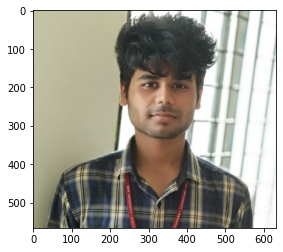

man in blue shirt is sitting on bench


In [ ]:
img = cv2.imread('/content/drive/My Drive/data/My pic/Myimage.jpg',1)
RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()
print(result)

In [ ]:
photo = fresh_image_features('/content/drive/My Drive/data/My pic/2654514044_a70a6e2c21.jpg')
description = generate_desc(model,tokenizer,photo,max_length)
stopwords = ['startseq','endseq']
words = description.split()

result = [word for word in words if word.lower() not in stopwords]
result = ' '.join(result)

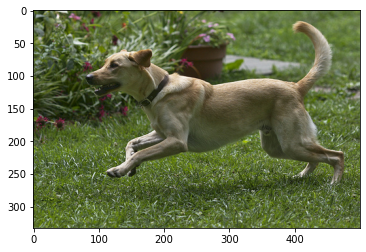

brown dog is running through the snow


In [ ]:
img = cv2.imread('/content/drive/My Drive/data/My pic/2654514044_a70a6e2c21.jpg',1)
RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()
print(result)